In [1]:
# Training vs Testing Errors
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Iris dataset
iris = datasets.load_iris()

X = iris.data
# Here for convenience, we divide the 3 kinds of flowers into 2 groups: 
#     Y = 0 (or False):  Setosa (original value 0) / Versicolor (original value 1)
#     Y = 1 (or True):   Virginica (original value 2)

# Thus we use (iris.target > 1.5) to divide the targets into 2 groups. 
# This line of code will assign:
#    Y[i] = True  (which is equivalent to 1) if iris.target[k]  > 1.5 (Virginica)
#    Y[i] = False (which is equivalent to 0) if iris.target[k] <= 1.5 (Setosa / Versicolor)
Y = (iris.target > 1.5).reshape(-1,1)

X_and_Y = np.hstack((X, Y))
np.random.seed(1)
np.random.shuffle(X_and_Y)

print(X.shape)
print(Y.shape)
print(X_and_Y[0])

(150, 4)
(150, 1)
[5.8 4.  1.2 0.2 0. ]


In [2]:
# Split into training and testing set
X_shuffled = X_and_Y[:, :4]
Y_shuffled = X_and_Y[:, 4]

X_train = X_shuffled[:100]
Y_train = Y_shuffled[:100]

X_test = X_shuffled[100:]
Y_test = Y_shuffled[100:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(100, 4)
(100,)
(50, 4)
(50,)


In [3]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, Y_train)
print(reg.coef_)
print(reg.intercept_)

[ 0.13065332  0.12253939 -0.12009986  0.67851079]
-1.1739130677104068


In [4]:
# Training and Testing error of regression and classification model
def reg_and_class_err(x, y):
    w = reg.coef_
    b = reg.intercept_
    
    reg_diff = 0
    class_diff = 0
    
    for i in range(len(x)):
        # prediciton based on x
        y_hat = np.dot(w, x[i, :]) + b
        
        # regression error, doing the sum here
        reg_diff += (y_hat - y[i]) ** 2
        
        # classification error
        y_hat_binary = 1 if y_hat >= 0.5 else 0
        class_diff += (y_hat_binary != y[i])
        
    # regression error, calculate the mean and square root here
    reg_diff = (reg_diff / len(x)) ** (0.5)
    class_diff /= len(x)
    
    return reg_diff, class_diff

print('Training regression and classification errors are:')
print(reg_and_class_err(X_train, Y_train))
print('Testing regression and classification errors are:')
print(reg_and_class_err(X_test, Y_test))

Training regression and classification errors are:
(0.27920692706242634, 0.06)
Testing regression and classification errors are:
(0.33046623492235216, 0.14)


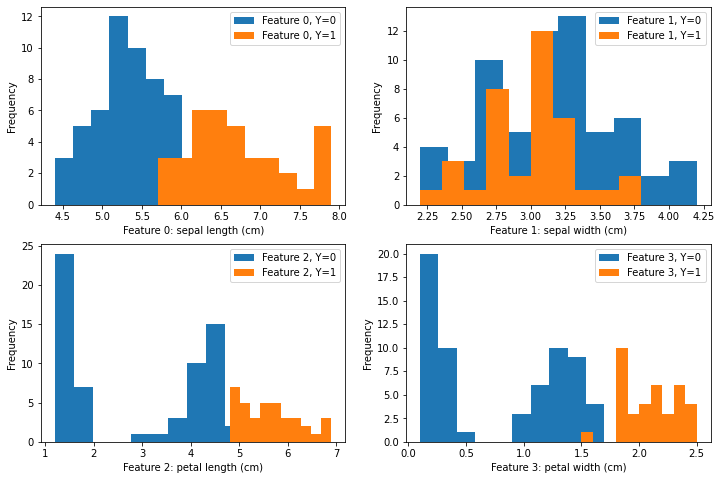

In [5]:
# Decision Stump
# Histograms for each feature
plt.figure(figsize=(12, 8))

for j in range(4):
    Xj_train = X_train[:, j]
    Xj_when_Y0_train = [Xj_train[i] for i in range(len(Xj_train)) if Y_train[i] == 0]
    Xj_when_Y1_train = [Xj_train[i] for i in range(len(Xj_train)) if Y_train[i] == 1]

    plt.subplot(2, 2, j+1)
    plt.hist(Xj_when_Y0_train, label='Feature {}, Y=0'.format(j))
    plt.hist(Xj_when_Y1_train, label='Feature {}, Y=1'.format(j))
    plt.xlabel('Feature {}: {}'.format(j, iris.feature_names[j]))
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

In [6]:
# Find the best feature and best threshold based on highest accuracy on training set
# Calculate the accuracy of prediciton given feature, target, and threshold
def calc_acc(Xj, Y, thres):
    # Calculate the accuracy given feature, target and threshold.
    #     Xj:    j-th feature. This array only contains 1 feature for all data points, 
    #            so the shape should be (count of data points,)
    #     Y:     Target array. Shape: (count of data points,)
    #     thres: Threshold.
    # Return the accuracy of prediction.
    
    # Count the number of correct predicitons and incorrect predictions
    # For simplicity we assume:
    #     If feature <= threshold, we predict it as Y = 0
    #     If feature > threshold, we predict it as Y = 1
    n_correct = 0
    n_incorrect = 0
    
    for i in range(0, len(Xj)):
        predY = 1
        if Xj[i] <= thres:
            predY = 0
        if predY != Y[i]:
            n_incorrect += 1
        else:
            n_correct += 1
            
    # Calculate the accuracy
    acc = 1.0 * n_correct / (n_correct + n_incorrect)
    
    return acc

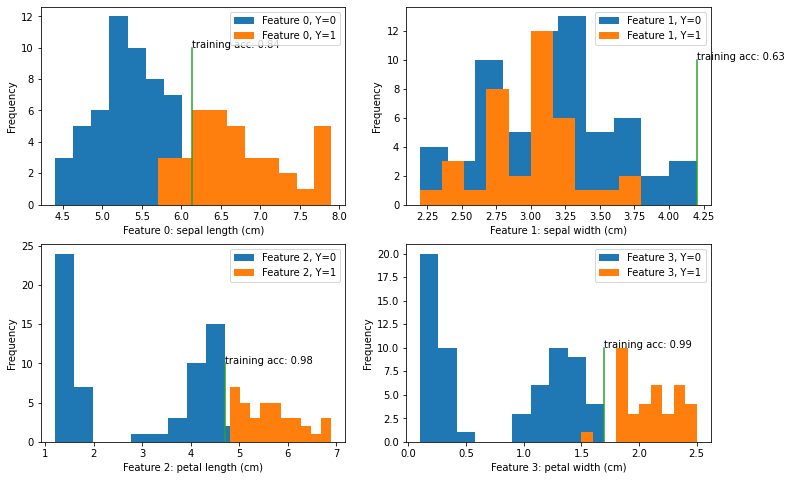

In [7]:
# show the histograms of each feature with accuracy
plt.figure(figsize=(12, 8))

all_max_acc = 0.0  # Max training accuracy among all features.
all_thres   = None # Threshold when reach the max training accuracy.
all_feature = None # Index of feature when reach the max training accuracy.

# Loop over 4 features. j: index of current feature
for j in range(4):
    # Get the data
    Xj_train = X_train[:, j] 
    Xj_when_Y0_train = [Xj_train[i] for i in range(len(Xj_train)) if Y_train[i] == 0]
    Xj_when_Y1_train = [Xj_train[i] for i in range(len(Xj_train)) if Y_train[i] == 1]
    
    current_max_acc = 0.0    # Max training accuracy in current feature.
    current_thres   = None   # Threshold when reach the max accuracy in current feature.
    
    # Loop through all possible values for threshold. Here weconsider 100 numbers between min and max of current feature
    for thres in np.linspace(Xj_train.min(), Xj_train.max(), 100):
        # Calculate the accuracy on training data given feature, target, and threshold
        acc = calc_acc(Xj_train, Y_train, thres)
        # Update the current max accuracy if possible
        if acc > current_max_acc:
            current_max_acc = acc
            current_thres = thres
            
    # Update the max training accuracy among all features if possible
    if current_max_acc > all_max_acc:
        all_max_acc = current_max_acc
        all_thres = current_thres
        all_feature = j
        
    plt.subplot(2, 2, j+1)
    plt.hist(Xj_when_Y0_train, label='Feature {}, Y=0'.format(j))
    plt.hist(Xj_when_Y1_train, label='Feature {}, Y=1'.format(j))
    plt.plot([current_thres, current_thres], [0, 10])
    plt.text(current_thres, 10, 'training acc: {}'.format(current_max_acc))
    plt.xlabel('Feature {}: {}'.format(j, iris.feature_names[j]))
    plt.ylabel('Frequency')
    plt.legend()

plt.show()

In [8]:
# Best feature and threshold on test set
Xj_test = X_test[:, all_feature]
test_acc = calc_acc(Xj_test, Y_test, all_thres)
print('Best feature: {}'.format(all_feature))
print('Best threshold: {:.2f}'.format(all_thres))
print('Training accuracy of best feature: {:.2f}'.format(all_max_acc))
print('Test accuracy of best feature: {:.2f}'.format(test_acc))

Best feature: 3
Best threshold: 1.70
Training accuracy of best feature: 0.99
Test accuracy of best feature: 0.90
